In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: cuda
Device name: NVIDIA GeForce GTX 1650


In [96]:
data = pd.read_csv("Dataset_English_Hindi.csv")
data.sample(5)

,English,Hindi
44867,“ But since it is a decision that has politica...,"नुस्ली कहते हैं , ' ' चूंकि इस पर फैसले से राज..."
26613,The length of the runways at the Port Blair an...,पोर्ट लेयर और कार निकोबार हवाई अड्डंओं पर हवाई...
120597,"That bloody 1814-16 Anglo - Nepal was war, in ...",इसी वजह से १८१४-१६ रक्तरंजित एंग्लो-नेपाल युद्...
114482,Their contempt for the law comes also from the...,उनमें कानून के लिए अवज्ञा का भाव अपनी इस जानका...
7921,"Because by definition,",क्यूंकि परिभाषा से


In [97]:
mask = data['English'].apply(lambda x: isinstance(x, str)) & data['Hindi'].apply(lambda x: isinstance(x, str))
data = data.loc[mask].copy()
data['English'] = data['English'].str.lower()
data['Hindi'] = data['Hindi'].str.lower()

In [98]:
MAX_SENT_LEN = 15
data = data[data['English'].str.split().apply(len) < MAX_SENT_LEN].copy()
data.reset_index(drop=True, inplace=True)
print(f"Rows after filtering: {len(data)}")

Rows after filtering: 77743


<Axes: title={'center': 'Distribution of English Sentence Lengths'}, ylabel='Frequency'>

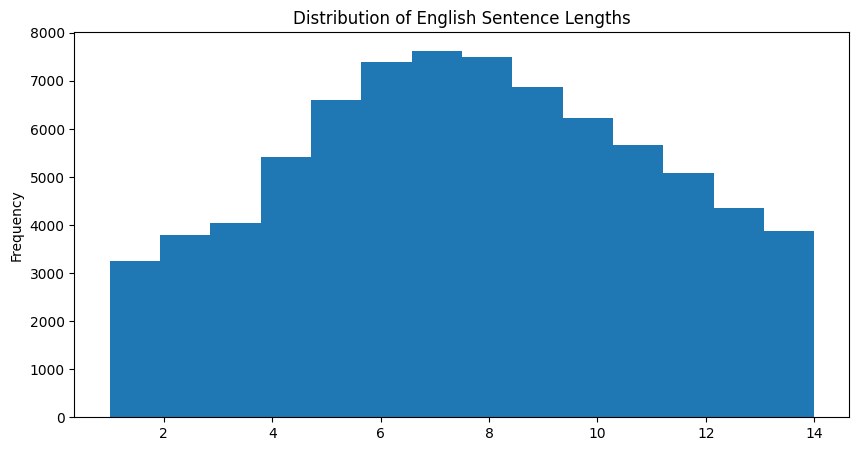

In [99]:
data['English'].str.split().apply(len).plot(kind='hist', bins=14, title='Distribution of English Sentence Lengths', figsize=(10, 5))

In [100]:
class Tokenizer:
    def __init__(self, texts):
        self.oov_token = "<|unknown|>"
        self.start_token = "<|startoftext|>"
        self.end_token = "<|endoftext|>"
        self.padding_token = "<|pad|>"
        self.word_index = {self.oov_token: 0, self.start_token: 1, self.end_token: 2, self.padding_token: 3}
    
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')

            text = text.split()
            for word in text:
                if word not in self.word_index:
                    self.word_index[word] = len(self.word_index) + 1
        self.index_word = {idx : word for word, idx in self.word_index.items()}

        self.vocab_size = len(self.word_index)
    def encode(self, texts):
        tokenized_texts = []
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')
            tokenized_text = []
            text = text.split()
            for word in text:
                tokenized_text.append(self.word_index.get(word, self.word_index[self.oov_token]))
            tokenized_texts.append(tokenized_text)
        return tokenized_texts
    def decode(self, sequences):
        decoded_texts = []
        for sequence in sequences:
            decoded_text = []
            for index in sequence:
                decoded_text.append(self.index_word.get(index, self.oov_token))
            decoded_texts.append(' '.join(decoded_text))
        return decoded_texts

In [101]:
eng_tokenizer = Tokenizer(data['English'])
hin_tokenizer = Tokenizer(data['Hindi'])
print(f"English Vocabulary Size: {eng_tokenizer.vocab_size}")# 80223
print(f"Hindi Vocabulary Size: {hin_tokenizer.vocab_size}")# 85059

English Vocabulary Size: 43114
Hindi Vocabulary Size: 43014


In [102]:
tokenized_text = eng_tokenizer.encode(["hello how are you raj neelam gaurav convolution", "this is a test", "what is your name"])
print(tokenized_text)
print(eng_tokenizer.decode(tokenized_text))
print()
tokenized_text = hin_tokenizer.encode(["नमस्ते आप कैसे हैं राज नीलम गौरव कन्वोल्यूशन", "यह एक परीक्षण है", "तुम्हारा नाम क्या है"])
print(tokenized_text)
print(hin_tokenizer.decode(tokenized_text))

[[7, 82, 83, 62, 8266, 26951, 0, 0], [94, 104, 110, 2144], [123, 104, 183, 306]]
['hello how are you raj neelam <|unknown|> <|unknown|>', 'this is a test', 'what is your name']

[[27205, 122, 123, 124, 3305, 28591, 5206, 0], [143, 111, 14354, 80], [404, 433, 114, 80]]
['नमस्ते आप कैसे हैं राज नीलम गौरव <|unknown|>', 'यह एक परीक्षण है', 'तुम्हारा नाम क्या है']


In [103]:
EMBED_DIM = 64
HIDDEN_DIM = 128
BATCH_SIZE = 128

In [104]:
# shuffle data
print(data.head())
data = data.sample(frac=1).reset_index(drop=True)
print(data.head())

  English    Hindi
0   help!    बचाओ!
1   jump.    उछलो.
2   jump.    कूदो.
3   jump.   छलांग.
4  hello!  नमस्ते।
                                             English  \
0                                     dictation - ol   
1  the fact is , turfing out enron will do india ...   
2                supreme court's region of authority   
3                                   for future study   
4  there was nothing in a country of 140 million ...   

                                               Hindi  
0                                  श्रुतलेखन-राजभाषा  
1  लेकिन सचाई यह है कि एनरॉन को उखाड़े फेंकने से ...  
2                 सर्वोच्च न्यायालय का क्षेत्राधिकार  
3                               आगे के अध्ययन के लिए  
4     इस 140 करोड़ लोगों के देश में कुछ भी नहीं था -  


In [105]:
class MyDataset(Dataset):
    def __init__(self, data, eng_tokenizer, hin_tokenizer):
        self.data = data
        self.eng_tokenizer = eng_tokenizer
        self.hin_tokenizer = hin_tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eng_text = self.data.iloc[idx]['English']
        hin_text = self.data.iloc[idx]['Hindi']

        eng_tokenized = self.eng_tokenizer.encode([eng_text])[0]
        if len(eng_tokenized) > MAX_SENT_LEN:
            eng_tokenized = eng_tokenized[:MAX_SENT_LEN]

        eng_padded = [self.eng_tokenizer.word_index[self.eng_tokenizer.padding_token]] * (MAX_SENT_LEN - len(eng_tokenized)) + eng_tokenized

        hin_tokenized = self.hin_tokenizer.encode([hin_text])[0]

        if len(hin_tokenized) > MAX_SENT_LEN - 2:
            hin_tokenized = hin_tokenized[:MAX_SENT_LEN - 2]
        hin_padded = [self.hin_tokenizer.word_index[self.hin_tokenizer.start_token]] + hin_tokenized + [self.hin_tokenizer.word_index[self.hin_tokenizer.end_token]] + [self.hin_tokenizer.word_index[self.hin_tokenizer.padding_token]] * (MAX_SENT_LEN - len(hin_tokenized) - 2)

        return {
            'eng_input': torch.tensor(eng_padded),
            'hin_target': torch.tensor(hin_padded)
        }

dataset = DataLoader(MyDataset(data, eng_tokenizer, hin_tokenizer), batch_size=BATCH_SIZE, shuffle=True)

In [106]:
class Encoder(nn.Module):
    def __init__(self, input_dim, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, EMBED_DIM)
        self.rnn = nn.LSTM(EMBED_DIM, HIDDEN_DIM, num_layers, batch_first=True)

    def forward(self, src):
        """
        src: (batch_size, src_len)
        """
        embedded = self.embedding(src)               # (B, T, E)
        outputs, hidden = self.rnn(embedded)         # outputs: all h_t, hidden: last h_T
        return outputs, hidden                       # hidden = context vector

In [107]:
class Decoder(nn.Module):
    def __init__(self, output_dim, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, EMBED_DIM)
        self.rnn = nn.LSTM(EMBED_DIM, HIDDEN_DIM, num_layers, batch_first=True)
        self.fc = nn.Linear(HIDDEN_DIM, output_dim)

    def forward(self, input_token, hidden):
        """
        input_token: (batch_size) → y_{t-1}
        hidden: context / previous hidden
        """
        input_token = input_token.unsqueeze(1)       # (B, 1)
        embedded = self.embedding(input_token)        # (B, 1, E)

        output, hidden = self.rnn(embedded, hidden)   # RNN step
        prediction = self.fc(output.squeeze(1))      # (B, vocab)

        return prediction, hidden

In [108]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        src: (B, src_len)
        trg: (B, trg_len)
        """
        batch_size = trg.size(0)
        trg_len = trg.size(1)
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
 
        _, hidden = self.encoder(src)     # CONTEXT VECTOR


        input_token = trg[:, 0]           # <start>

        for t in range(1, trg_len):
            output, hidden = self.decoder(input_token, hidden)
            outputs[:, t] = output

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)

            input_token = trg[:, t] if teacher_force else top1

        return outputs

In [109]:
encoder = Encoder(input_dim=eng_tokenizer.vocab_size+1)
decoder = Decoder(output_dim=hin_tokenizer.vocab_size+1)

model = Seq2Seq(encoder, decoder, device).to(device)


In [110]:
# # load saved weights and set model to evaluation mode
# checkpoint_path = "models/LSTM_model_epoch_20_batch_601.pth"
# state_dict = torch.load(checkpoint_path, map_location=device)
# model.load_state_dict(state_dict)
# model.to(device)
# model.train()

In [111]:
crition = nn.CrossEntropyLoss(ignore_index=hin_tokenizer.word_index[hin_tokenizer.padding_token])
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [112]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    # print(f"Model saved to {filepath}")
torch.cuda.empty_cache()

In [113]:
EPOCHS = 30
history = []
average_losses = []
for epoch in range(EPOCHS):
    loss=0
    tqdm_bar = tqdm(dataset)
    for i, batch in enumerate(tqdm_bar):
        
        if i % 300 == 0:
            save_model(model, f"models/LSTM_model_epoch_{epoch+1}_batch_{i+1}.pth")
        # load batch to device
        X, y = batch['eng_input'].to(device), batch['hin_target'].to(device)
        # forward pass
        logits = model(X, y)
        loss = crition(logits.view(-1, logits.size(-1)), y.view(-1))
        la = 'UND' if len(history)<40 else f"{(sum(history[-40:])/40):.4f}"
        tqdm_bar.set_postfix({"loss_avg": la, "current_loss": f"{loss.item():.4f}"})
        tqdm_bar.set_description(f"Epoch: {epoch+1}")

        #flush
        # del batch, X, y, logits
        # torch.cuda.empty_cache()
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping
        optimizer.step()

        history.append(loss.item())
        if len(history)>40:
            average_losses.append(sum(history[-40:])/40)
    

  0%|          | 0/608 [00:00<?, ?it/s]

Epoch: 30: 100%|██████████| 608/608 [02:54<00:00,  3.48it/s, loss_avg=3.3915, current_loss=3.8589]


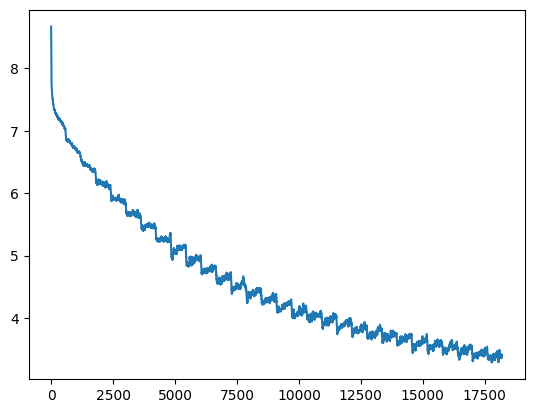

In [114]:
plt.plot(average_losses)

In [115]:
def translate_sentence(model, sentence, eng_tokenizer, hin_tokenizer, device, max_len=MAX_SENT_LEN):
    model.eval()  # Set model to evaluation mode
    
    # 1. Preprocess and Tokenize the input sentence
    sentence = sentence.lower().replace('!', '').replace('.', '').replace('?', '')
    tokens = eng_tokenizer.encode([sentence])[0]
    
    # 2. Pad the sequence (matching your training logic: left-padding)
    padding_idx = eng_tokenizer.word_index[eng_tokenizer.padding_token]
    padded_tokens = [padding_idx] * (max_len - len(tokens)) + tokens
    src_tensor = torch.LongTensor(padded_tokens).unsqueeze(0).to(device) # (1, max_len)

    with torch.no_grad():
        # 3. Pass through Encoder to get the context vector
        _, hidden = model.encoder(src_tensor)

        # 4. Prepare the Decoder input (starting with <|startoftext|>)
        start_idx = hin_tokenizer.word_index[hin_tokenizer.start_token]
        end_idx = hin_tokenizer.word_index[hin_tokenizer.end_token]
        
        input_token = torch.LongTensor([start_idx]).to(device)
        
        translated_indices = []

        # 5. Decode step-by-step
        for _ in range(max_len):
            output, hidden = model.decoder(input_token, hidden)
            
            # Get the word with the highest probability
            top1 = output.argmax(1)
            idx = top1.item()
            
            # Stop if we reach the <|endoftext|> token
            if idx == end_idx:
                break
                
            translated_indices.append(idx)
            input_token = top1 # Next input is the current prediction

    # 6. Convert indices back to words
    translated_sentence = hin_tokenizer.decode([translated_indices])[0]
    return translated_sentence

# --- Usage Example ---
input_str = "hello how are you my friend"
translation = translate_sentence(model, input_str, eng_tokenizer, hin_tokenizer, device)
print(f"Input: {input_str}")
print(f"Output: {translation}")

Input: hello how are you my friend
Output: मेरी जगह कैसे कैसे कर चुके हैं
